# * Business Growth Overview *

## Note :

### Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

## Import Data Source
Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
# import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

##### *** "TDG Revenue (Performance View)" or "TDG Revenue (Conso View)" ? : 
- AGG_TYPE = N

In [2]:
''' Config '''

config = configparser.ConfigParser()
config.read('../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']

In [3]:
data_src = f"../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00143'] # include "TDG Revenue (Conso View)"
# tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list
# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
# bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

''' Fix Agg Column Name(Total Revenue) '''
bg_col_list = ['POST_DTAC', 'POST_TMH', 'PRE_DTAC', 'PRE_TMH', 'TOL', 'TVS']

In [4]:
df.shape

(47969, 13)

In [5]:
# ''' Find Metric '''

# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# # df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # # df_tmp.to_excel('Prepaid_Metric.xlsx')
# # df_tmp

## Data Preporation

In [6]:
''' Function '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

In [7]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202306] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,AGG_TYPE,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
44266,20230724,2023030,202307,20233,2023,TB4R000100,TVS Revenue,S,NaN,215.007384,NaN,230.053922,2023-07-27 17:32:34,July,30,24
44267,20230725,2023030,202307,20233,2023,TB4R000100,TVS Revenue,S,12.018499,227.025883,30.522542,260.576464,2023-07-27 17:32:34,July,30,25
44268,20230726,2023030,202307,20233,2023,TB4R000100,TVS Revenue,S,NaN,227.025883,NaN,260.576464,2023-07-27 17:32:34,July,30,26


In [8]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [9]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [10]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1329,44266,TB4R000100,TVS Revenue,20230724,2023030,202307,20233,2023,July,24,...,215.007384,NaN,230.053922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1330,44267,TB4R000100,TVS Revenue,20230725,2023030,202307,20233,2023,July,25,...,227.025883,30.522542,260.576464,12.018499,30.522542,0.393758,-18.504043,NaN,NaN,NaN
1331,44268,TB4R000100,TVS Revenue,20230726,2023030,202307,20233,2023,July,26,...,227.025883,NaN,260.576464,NaN,NaN,NaN,NaN,12.018499,NaN,NaN


In [11]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
             'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
             'TDG Revenue (Conso View)': 'TDG', 'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

In [12]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
145           20230724   2023030     202307      20233      2023     July   
146           20230725   2023030     202307      20233      2023     July   
147           20230726   2023030     202307      20233      2023     July   

            DAY_LABEL ACT_SNAP                      ... DIFF %DOD            \
METRIC_NAME               POST  POST_DTAC POST_TMH  ...  TVS POST POST_DTAC   
145                24      NaN  86.963981      NaN  ...  NaN  NaN  0.014371   
146                25      NaN        NaN      NaN  ...  NaN  NaN       NaN   
147                26      NaN        NaN      NaN  ...  NaN  NaN       NaN   

                                                              
METRIC_NAME POST_TMH PRE  PRE_DTAC PRE_TMH       TDG TOL TVS  
145              NaN NaN  0.047159     NaN -0.033473 NaN NaN  
146              NaN NaN       NaN     NaN  0.000000 NaN NaN  
147              NaN NaN       NaN     NaN  0.000000 NaN NaN  

[3 rows x 70 columns]

In [13]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
145           20230724   2023030     202307      20233      2023     July   
146           20230725   2023030     202307      20233      2023     July   
147           20230726   2023030     202307      20233      2023     July   

            DAY_LABEL ACT_SNAP                      ...      %DOD          \
METRIC_NAME               POST  POST_DTAC POST_TMH  ...       TDG TOL TVS   
145                24      NaN  86.963981      NaN  ... -0.033473 NaN NaN   
146                25      NaN        NaN      NaN  ...  0.000000 NaN NaN   
147                26      NaN        NaN      NaN  ...  0.000000 NaN NaN   

                 ACT_BG      TGT_BG  %ACHV_BG      GAP_BG LAST_ACT_BG  \
METRIC_NAME                                                             
145          137.648316  135.070575  1.019084    2.577741  134.133705   
146           12.629616  189.459602  0.066661 -176.829986  137.648316   
147            0.000000    0.000000       NaN    0.000000   12.629616   

                DIFF_BG   %DOD_BG  
METRIC_NAME                        
145            3.514611  0.026202  
146         -125.018700 -0.908247  
147          -12.629616 -1.000000  

[3 rows x 77 columns]

## ** Yearly **

### YR : Aggregation

In [14]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,S,17311.117893,17301.728371,1.000543,9.389522,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,S,31133.128112,31612.049370,0.984850,-478.921259,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,S,7605.030335,7718.430608,0.985308,-113.400274,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,14097.211083,14305.659932,0.985429,-208.448848,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH,2023,S,9805.173660,9679.379600,1.012996,125.794060,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,S,17208.612948,17480.689799,0.984436,-272.076851,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,S,6805.853303,7412.537833,0.918154,-606.684531,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,S,1519.600900,1915.041847,0.793508,-395.440947,NaN,NaN,NaN
37606,TNSC00143,TDG Revenue (Conso View),2023,N,231.000000,258.000000,0.895349,-27.000000,NaN,NaN,NaN


In [15]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  31133.128112  14097.211083  17208.612948  17311.117893   

                                                                     ... DIFF  \
METRIC_NAME     PRE_DTAC     PRE_TMH    TDG          TOL        TVS  ...  TVS   
0            7605.030335  9805.17366  231.0  6805.853303  1519.6009  ...  NaN   

            %YOY                                                      
METRIC_NAME POST POST_DTAC POST_TMH PRE PRE_DTAC PRE_TMH TDG TOL TVS  
0            NaN       NaN      NaN NaN      NaN     NaN NaN NaN NaN  

[1 rows x 64 columns]

In [16]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  31133.128112  14097.211083  17208.612948  17311.117893   

                                                                     ... %YOY  \
METRIC_NAME     PRE_DTAC     PRE_TMH    TDG          TOL        TVS  ...  TDG   
0            7605.030335  9805.17366  231.0  6805.853303  1519.6009  ...  NaN   

                           ACT_BG        TGT_BG  %ACHV_BG       GAP_BG  \
METRIC_NAME TOL TVS                                                      
0           NaN NaN  57041.482228  58511.739619  0.974872 -1470.257391   

            LAST_ACT_BG DIFF_BG %YOY_BG  
METRIC_NAME                              
0                   0.0     0.0     0.0  

[1 rows x 71 columns]

In [17]:
''' BG Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_26680\801060286.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [18]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_SNAP']['POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_SNAP']['POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_SNAP']['POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_SNAP']['PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_SNAP']['PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_SNAP']['PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_SNAP']['TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_SNAP']['TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_SNAP']['TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_SNAP']['POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_SNAP']['POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_SNAP']['POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_SNAP']['PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_SNAP']['PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_SNAP']['PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_SNAP']['TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_SNAP']['TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV']['POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV']['POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV']['POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV']['PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV']['PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV']['PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV']['TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV']['TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV']['TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP']['POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP']['POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP']['POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP']['PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP']['PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP']['PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP']['TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP']['TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP']['TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT']['POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT']['POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT']['POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT']['PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT']['PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT']['PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT']['TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT']['TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF']['POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF']['POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF']['POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF']['PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF']['PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF']['PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF']['TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF']['TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF']['TVS']

''' % YOY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY']['POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY']['POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY']['POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY']['PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY']['PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY']['PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY']['TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY']['TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY']['TVS']

### YR : Visualizations

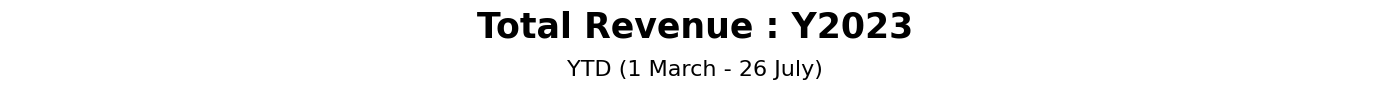

In [19]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

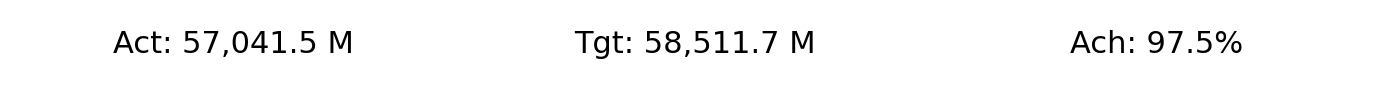

In [20]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

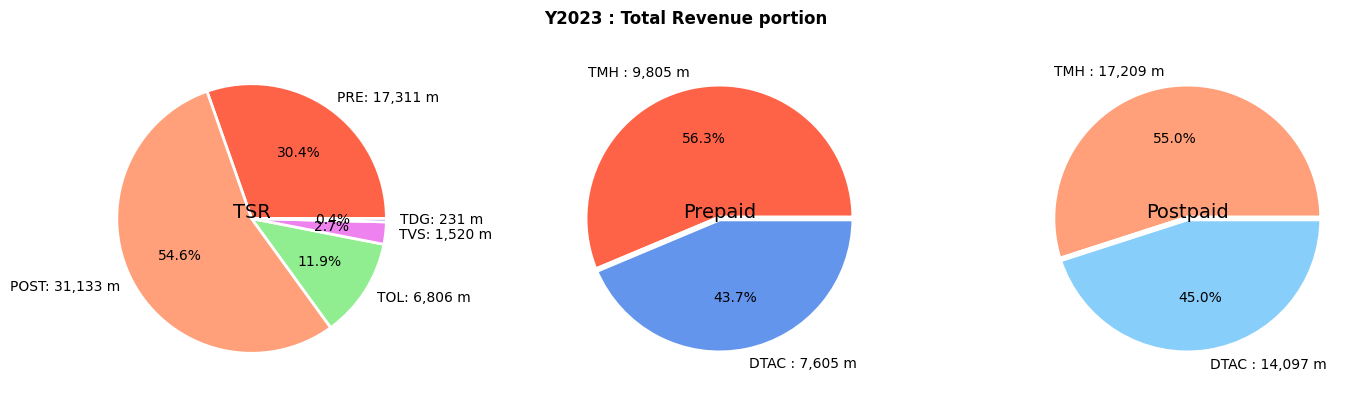

In [21]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : Total Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE: {format(y[0],',.0f')} m", f"POST: {format(y[1],',.0f')} m", f"TOL: {format(y[2],',.0f')} m", f"TVS: {format(y[3],',.0f')} m", f"TDG: {format(y[4],',.0f')} m"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'TSR', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [22]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
37487,TNSC00143,TDG Revenue (Conso View),202303,March,N,237.292177,288.0,0.823931,-50.707823,NaN,NaN,NaN
37515,TNSC00143,TDG Revenue (Conso View),202304,April,N,227.642043,295.0,0.771668,-67.357957,237.292177,-9.650133,-0.040668
37550,TNSC00143,TDG Revenue (Conso View),202305,May,N,242.243049,278.0,0.871378,-35.756951,227.642043,14.601006,0.064140
37578,TNSC00143,TDG Revenue (Conso View),202306,June,N,246.000000,254.0,0.968504,-8.000000,242.243049,3.756951,0.015509
37606,TNSC00143,TDG Revenue (Conso View),202307,July,N,231.000000,258.0,0.895349,-27.000000,246.000000,-15.000000,-0.060976


In [23]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
2               202305      May  6582.670122  2953.069229  3629.600893   
3               202306     June  6444.851566  2945.530956  3499.320610   
4               202307     July  4848.351140  2254.167998  2766.879062   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
2            3733.741967  1610.280929  2123.461039  242.243049  1429.437137   
3            3642.243926  1562.505355  2079.738571  246.000000  1443.876272   
4            2666.900359  1242.430476  1523.555984  231.000000  1125.621425   

             ...        DIFF      %MOM                                \
METRIC_NAME  ...         TVS      POST POST_DTAC  POST_TMH       PRE   
2            ...  102.524541 -0.010737 -0.002528 -0.017316  0.041584   
3            ...   -5.688854 -0.020937 -0.002553 -0.035894 -0.024506   
4            ... -143.505126 -0.247717 -0.234716 -0.209310 -0.267786   

                                                               
METRIC_NAME  PRE_DTAC   PRE_TMH       TDG       TOL       TVS  
2            0.025934  0.053774  0.064140  0.017020  0.374594  
3           -0.029669 -0.020590  0.015509  0.010101 -0.015121  
4           -0.204847 -0.267429 -0.060976 -0.220417 -0.387296  

[3 rows x 65 columns]

In [24]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
2               202305      May  6582.670122  2953.069229  3629.600893   
3               202306     June  6444.851566  2945.530956  3499.320610   
4               202307     July  4848.351140  2254.167998  2766.879062   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
2            3733.741967  1610.280929  2123.461039  242.243049  1429.437137   
3            3642.243926  1562.505355  2079.738571  246.000000  1443.876272   
4            2666.900359  1242.430476  1523.555984  231.000000  1125.621425   

             ...      %MOM                            ACT_BG        TGT_BG  \
METRIC_NAME  ...       TDG       TOL       TVS                               
2            ...  0.064140  0.017020  0.374594  12122.069090  12245.041865   
3            ...  0.015509  0.010101 -0.015121  11901.502774  12247.219233   
4            ... -0.060976 -0.220417 -0.387296   9139.680828   9526.592014   

             %ACHV_BG      GAP_BG   LAST_ACT_BG      DIFF_BG   %MOM_BG  
METRIC_NAME                                                             
2            0.989957 -122.972774  11918.002837   204.066253  0.017123  
3            0.971772 -345.716459  12122.069090  -220.566316 -0.018195  
4            0.959386 -386.911186  11901.502774 -2761.821946 -0.232057  

[3 rows x 72 columns]

In [25]:
''' BG Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [26]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_SNAP']['POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_SNAP']['POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_SNAP']['POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_SNAP']['PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_SNAP']['PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_SNAP']['PRE_TMH']
y_mth_act_tdg = df_rev_mth_agg['ACT_SNAP']['TDG']
y_mth_act_tol = df_rev_mth_agg['ACT_SNAP']['TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_SNAP']['TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_SNAP']['POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_SNAP']['POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_SNAP']['POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_SNAP']['PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_SNAP']['PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_SNAP']['PRE_TMH']
y_mth_tgt_tdg = df_rev_mth_agg['TGT_SNAP']['TDG']
y_mth_tgt_tol = df_rev_mth_agg['TGT_SNAP']['TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV']['POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV']['POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV']['POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV']['PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV']['PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV']['PRE_TMH']
y_mth_achv_tdg = df_rev_mth_agg['%ACHV']['TDG']
y_mth_achv_tol = df_rev_mth_agg['%ACHV']['TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV']['TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP']['POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP']['POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP']['POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP']['PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP']['PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP']['PRE_TMH']
y_mth_gap_tdg = df_rev_mth_agg['GAP']['TDG']
y_mth_gap_tol = df_rev_mth_agg['GAP']['TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP']['TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT']['POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT']['POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT']['POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT']['PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT']['PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT']['PRE_TMH']
y_mth_last_act_tdg = df_rev_mth_agg['LAST_ACT']['TDG']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT']['TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF']['POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF']['POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF']['POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF']['PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF']['PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF']['PRE_TMH']
y_mth_diff_tdg = df_rev_mth_agg['DIFF']['TDG']
y_mth_diff_tol = df_rev_mth_agg['DIFF']['TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF']['TVS']

''' % MOM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM']['POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM']['POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM']['POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM']['PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM']['PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM']['PRE_TMH']
y_mth_mom_tdg = df_rev_mth_agg['%MOM']['TDG']
y_mth_mom_tol = df_rev_mth_agg['%MOM']['TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM']['TVS']

### MTH : Visualizations

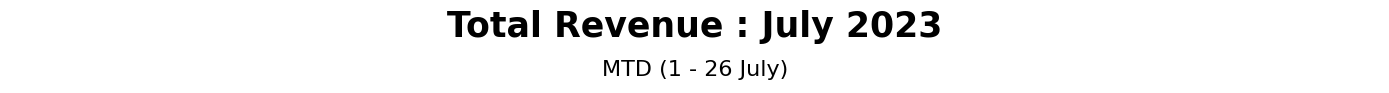

In [27]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

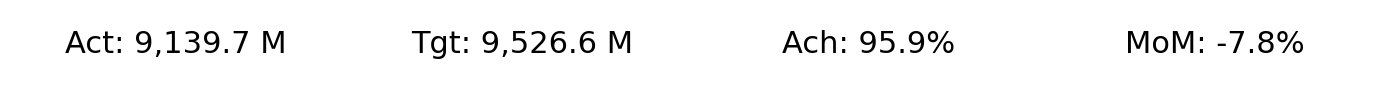

In [28]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

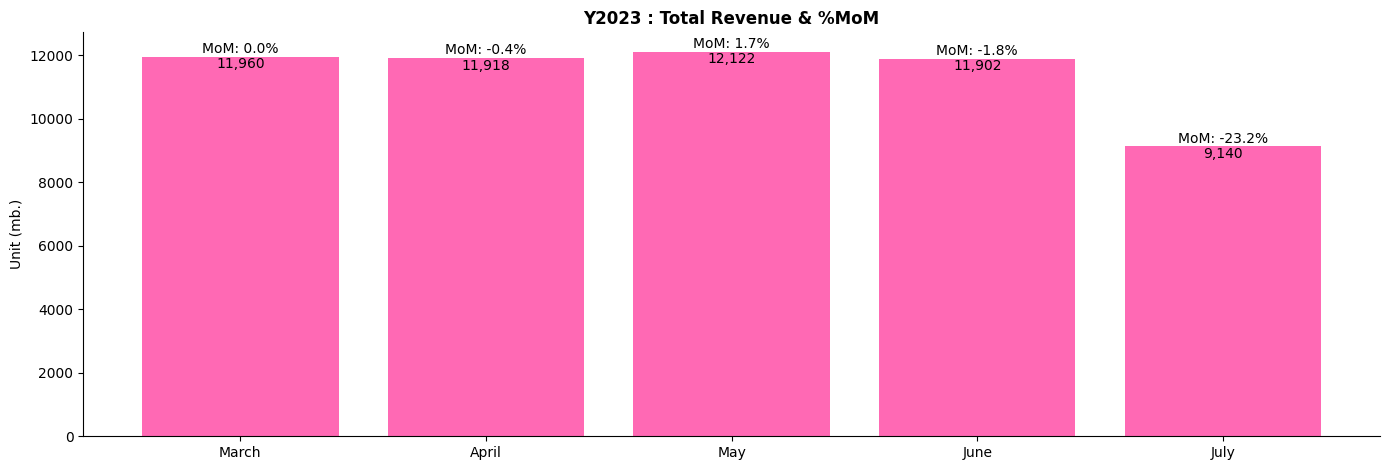

In [29]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

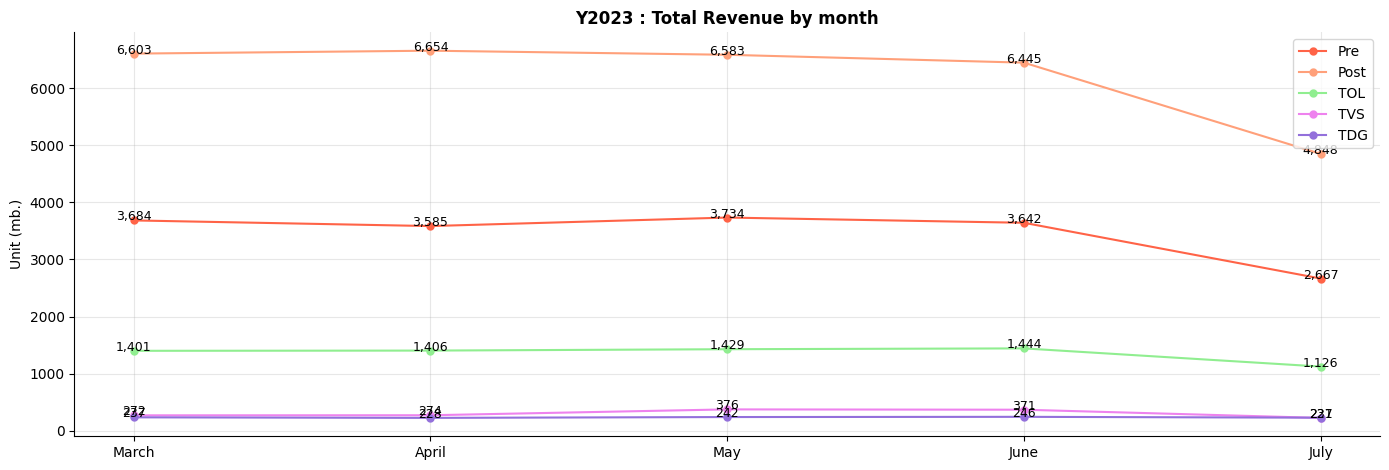

In [30]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

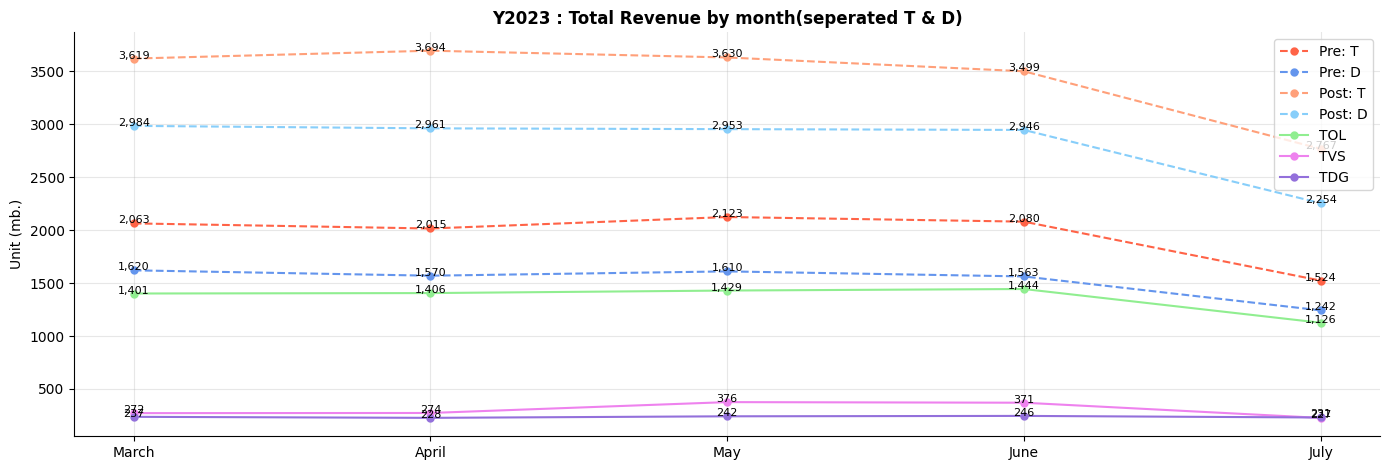

In [31]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month(seperated T & D)", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [32]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
37592,TNSC00143,TDG Revenue (Conso View),2023028,28,N,239.0,258.0,0.926357,-19.0,239.0,0.0,0.000000
37599,TNSC00143,TDG Revenue (Conso View),2023029,29,N,239.0,258.0,0.926357,-19.0,239.0,0.0,0.000000
37606,TNSC00143,TDG Revenue (Conso View),2023030,30,N,231.0,258.0,0.895349,-27.0,239.0,-8.0,-0.033473


In [33]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
19            2023028       28  1858.412188  626.173577  1232.238611   
20            2023029       29  1240.473445  618.734579   707.470804   
21            2023030       30     0.000000   86.963981     0.000000   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
19           817.811973  348.513216  469.298757  239.0  520.971208  ...   
20           695.203926  346.948688  396.657005  239.0  296.128610  ...   
21             0.000000   50.684335    0.000000  231.0    0.611117  ...   

                  DIFF      %WOW                                          \
METRIC_NAME        TVS      POST POST_DTAC  POST_TMH       PRE  PRE_DTAC   
19           90.949163  1.065681 -0.058856  4.258590 -0.062084 -0.070487   
20          -43.005238 -0.332509 -0.011880 -0.425865 -0.149922 -0.004489   
21          -48.191153 -1.000000 -0.859449 -1.000000 -1.000000 -0.853914   

                                                     
METRIC_NAME   PRE_TMH       TDG       TOL       TVS  
19          -0.055746  0.000000  3.710430  7.414902  
20          -0.154788  0.000000 -0.431584 -0.416657  
21          -1.000000 -0.033473 -0.997936 -0.800389  

[3 rows x 65 columns]

In [34]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
19            2023028       28  1858.412188  626.173577  1232.238611   
20            2023029       29  1240.473445  618.734579   707.470804   
21            2023030       30     0.000000   86.963981     0.000000   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
19           817.811973  348.513216  469.298757  239.0  520.971208  ...   
20           695.203926  346.948688  396.657005  239.0  296.128610  ...   
21             0.000000   50.684335    0.000000  231.0    0.611117  ...   

                 %WOW                           ACT_BG       TGT_BG  %ACHV_BG  \
METRIC_NAME       TDG       TOL       TVS                                       
19           0.000000  3.710430  7.414902  3300.410259  3426.057562  0.963326   
20           0.000000 -0.431584 -0.416657  2426.149338  2503.866212  0.968961   
21          -0.033473 -0.997936 -0.800389   150.277932   324.530177  0.463063   

                 GAP_BG  LAST_ACT_BG      DIFF_BG   %WOW_BG  
METRIC_NAME                                                  
19          -125.647302  1894.472183  1405.938076  0.742127  
20           -77.716874  3300.410259  -874.260922 -0.264895  
21          -174.252245  2426.149338 -2275.871405 -0.938059  

[3 rows x 72 columns]

In [35]:
''' BG Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())

# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [36]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_SNAP']['POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_SNAP']['POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_SNAP']['POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_SNAP']['PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_SNAP']['PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_SNAP']['PRE_TMH']
y_wk_act_tdg = df_rev_wk_agg['ACT_SNAP']['TDG']
y_wk_act_tol = df_rev_wk_agg['ACT_SNAP']['TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_SNAP']['TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_SNAP']['POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_SNAP']['POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_SNAP']['POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_SNAP']['PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_SNAP']['PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_SNAP']['PRE_TMH']
y_wk_tgt_tdg = df_rev_wk_agg['TGT_SNAP']['TDG']
y_wk_tgt_tol = df_rev_wk_agg['TGT_SNAP']['TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV']['POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV']['POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV']['POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV']['PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV']['PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV']['PRE_TMH']
y_wk_achv_tdg = df_rev_wk_agg['%ACHV']['TDG']
y_wk_achv_tol = df_rev_wk_agg['%ACHV']['TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV']['TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP']['POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP']['POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP']['POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP']['PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP']['PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP']['PRE_TMH']
y_wk_gap_tdg = df_rev_wk_agg['GAP']['TDG']
y_wk_gap_tol = df_rev_wk_agg['GAP']['TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP']['TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT']['POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT']['POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT']['POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT']['PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT']['PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT']['PRE_TMH']
y_wk_last_act_tdg = df_rev_wk_agg['LAST_ACT']['TDG']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT']['TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF']['POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF']['POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF']['POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF']['PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF']['PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF']['PRE_TMH']
y_wk_diff_tdg = df_rev_wk_agg['DIFF']['TDG']
y_wk_diff_tol = df_rev_wk_agg['DIFF']['TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF']['TVS']

''' % WOW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW']['POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW']['POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW']['POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW']['PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW']['PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW']['PRE_TMH']
y_wk_wow_tdg = df_rev_wk_agg['%WOW']['TDG']
y_wk_wow_tol = df_rev_wk_agg['%WOW']['TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW']['TVS']

### WK : Visualizations

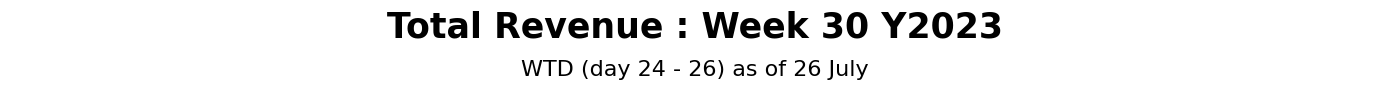

In [37]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

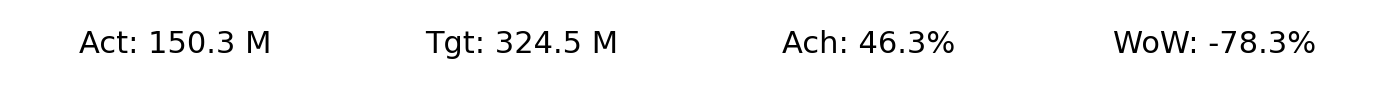

In [38]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

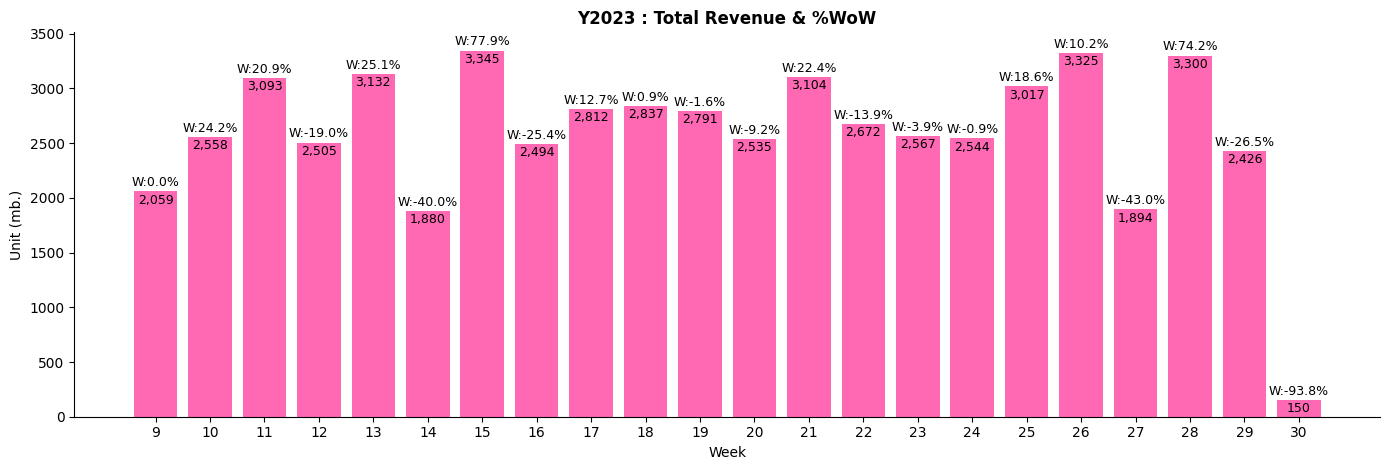

In [39]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %WoW", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"W:{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

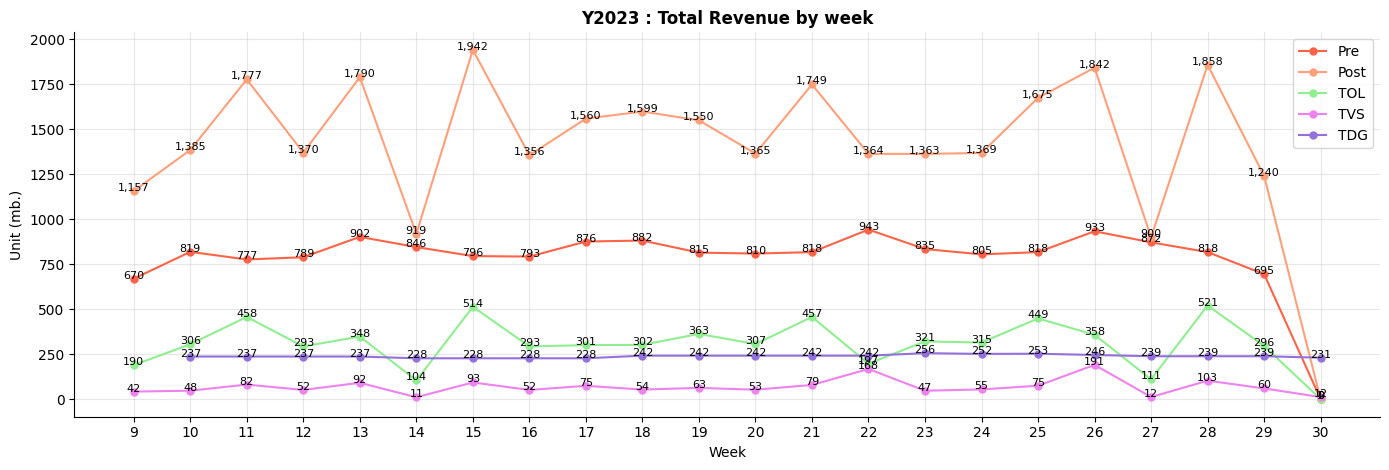

In [40]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

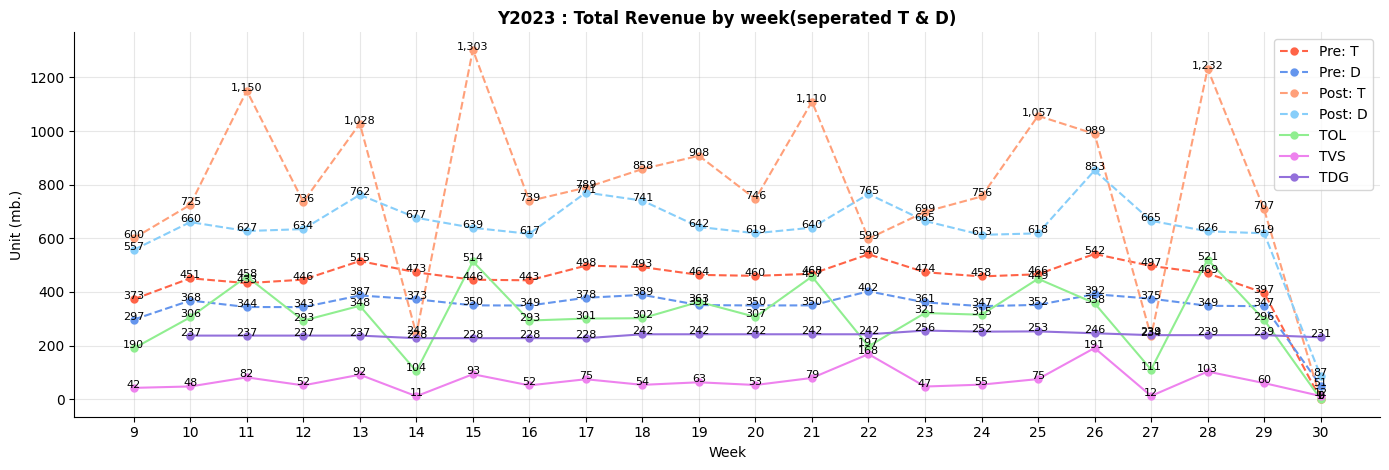

In [41]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week(seperated T & D)", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [42]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT_BG'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [43]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT_BG'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT_BG'].sum()
dtd_tgt = df_rev_day_curr_day['TGT_BG'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT_BG'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

In [44]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_SNAP']['POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_SNAP']['POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_SNAP']['POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_SNAP']['PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_SNAP']['PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_SNAP']['PRE_TMH']
y_day_act_tdg = df_rev_day_curr_mth['ACT_SNAP']['TDG']
y_day_act_tol = df_rev_day_curr_mth['ACT_SNAP']['TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_SNAP']['TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_SNAP']['POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_SNAP']['POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_SNAP']['POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_SNAP']['PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_SNAP']['PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_SNAP']['PRE_TMH']
y_day_tgt_tdg = df_rev_day_curr_mth['TGT_SNAP']['TDG']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_SNAP']['TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_SNAP']['TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV']['POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV']['POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV']['POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV']['PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV']['PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV']['PRE_TMH']
y_day_achv_tdg = df_rev_day_curr_mth['%ACHV']['TDG']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV']['TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV']['TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP']['POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP']['POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP']['POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP']['PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP']['PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP']['PRE_TMH']
y_day_gap_tdg = df_rev_day_curr_mth['GAP']['TDG']
y_day_gap_tol = df_rev_day_curr_mth['GAP']['TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP']['TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT']['POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT']['POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT']['POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT']['PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT']['PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT']['PRE_TMH']
y_day_last_act_tdg = df_rev_day_curr_mth['LAST_ACT']['TDG']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT']['TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF']['POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF']['POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF']['POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF']['PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF']['PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF']['PRE_TMH']
y_day_diff_tdg = df_rev_day_curr_mth['DIFF']['TDG']
y_day_diff_tol = df_rev_day_curr_mth['DIFF']['TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF']['TVS']

''' % DOD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD']['POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD']['POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD']['POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD']['PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD']['PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD']['PRE_TMH']
y_day_dod_tdg = df_rev_day_curr_mth['%DOD']['TDG']
y_day_dod_tol = df_rev_day_curr_mth['%DOD']['TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD']['TVS']

### DAY : Visualizations

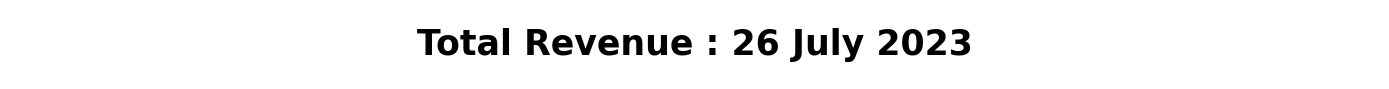

In [45]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

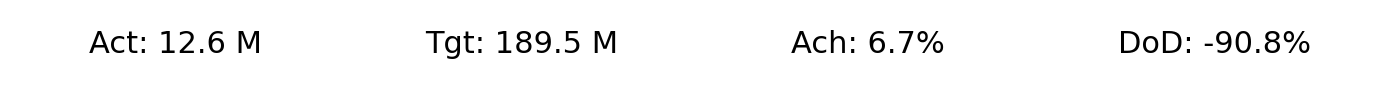

In [46]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(dtd_rev,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(dtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

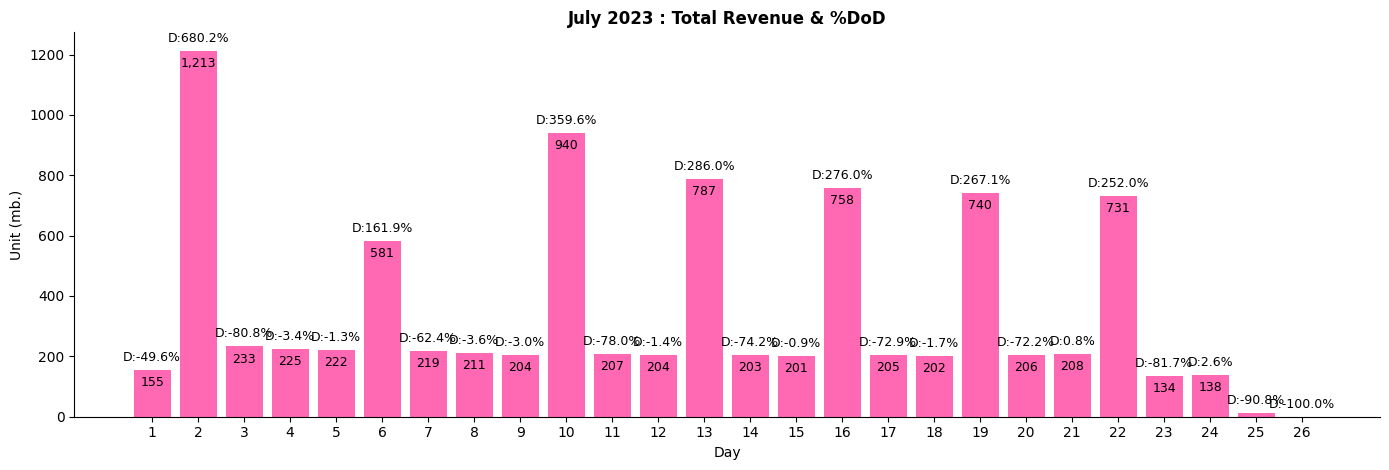

In [47]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue & %DoD", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"D:{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

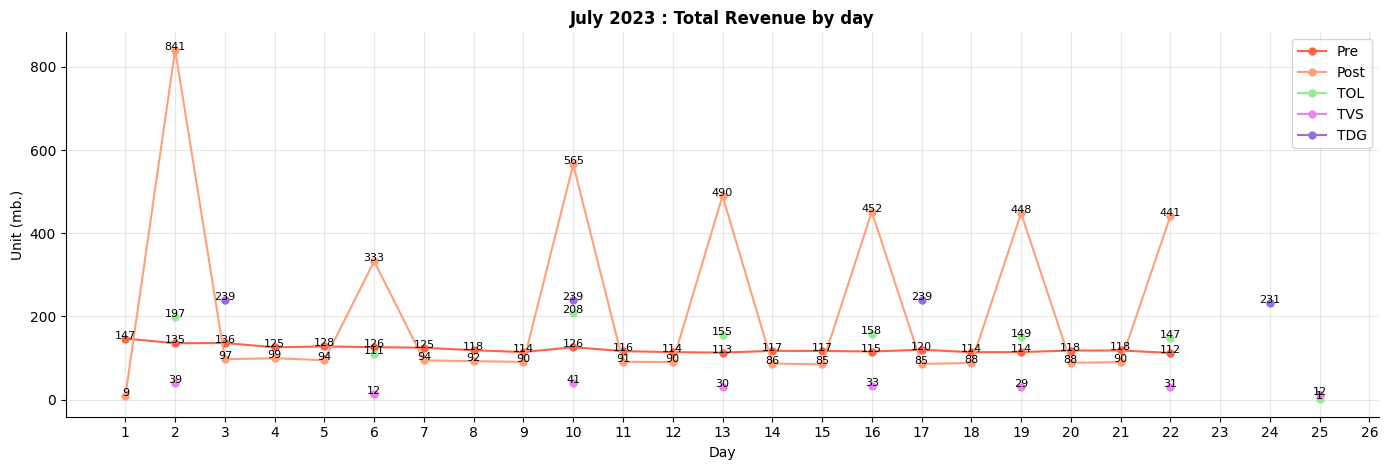

In [48]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

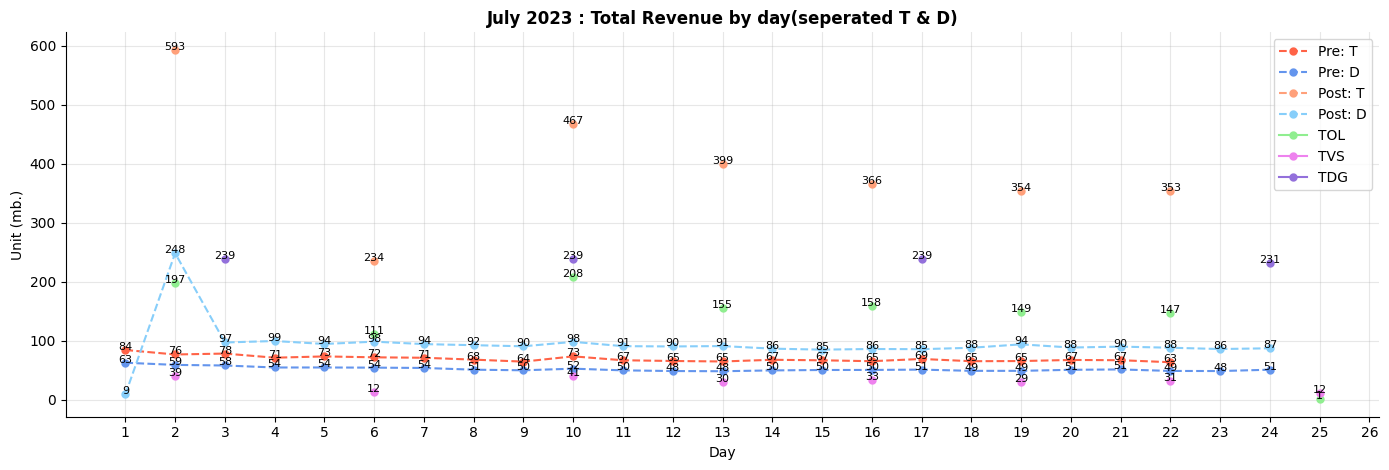

In [49]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day(seperated T & D)", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Generate Output Data

In [50]:
# df_rev_day.to_excel('../data/interim/df_rev_day.xlsx', index=False)
# df_rev_yr.to_excel('../data/interim/df_rev_yr.xlsx', index=False)
# df_rev_mth.to_excel('../data/interim/df_rev_mth.xlsx', index=False)
# df_rev_wk.to_excel('../data/interim/df_rev_wk.xlsx', index=False)